<a href="https://colab.research.google.com/github/vibhakargupta1/Fake-News-Detector/blob/main/Final_Minor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reddit Fake news score generator**

### Importing the libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns
from nltk import tokenize
token_space = tokenize.WhitespaceTokenizer()
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Bidirectional
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Import and Cleaning

In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/True.csv")

true['label'] = 'TRUE'
fake['label'] = 'FAKE'
news = pd.concat([true, fake])
news1 = news.sample(frac=1)

news1['article'] = news1['title'] + " " + news1['text'] + " " + news1['subject']
df_final = news1[['article','label']]
df_final.head()

,article,label
15321,Argentina congress passes law to fight corpora...,TRUE
15330,Senior Thai royal official dismissed in latest...,TRUE
14491,OUTRAGE AND DESPERATION: VIDEO Captures Americ...,FAKE
23364,Shock to The System: New Poll Says Trump CAN B...,FAKE
7561,Arizona ballot-collection law put on hold unti...,TRUE


In [ ]:
df_final['article'] = df_final['article'].apply(lambda x: x.lower())

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
  
df_final['article'] = df_final['article'].apply(clean_text)

df_final['article'] = df_final['article'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

### Text data analysis and visualizations

WordCloud for complete corpus

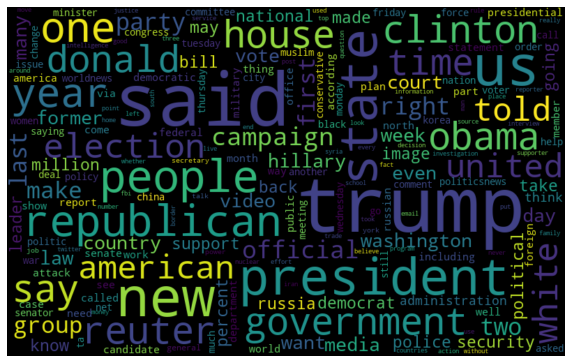

In [ ]:
#wordcloud for the whole corpus i.e. fake and true both
all_words = ' '.join([text for text in df_final.article])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#wordcloud generating function
def wordcloud_gen(dataframe, column_with_text, label):
    true_text = dataframe.query(f"label == '{label}'")
    all_words = ' '.join([text for text in true_text[column_with_text]])

    wordcloud = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(all_words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Word Cloud for Fake News articles

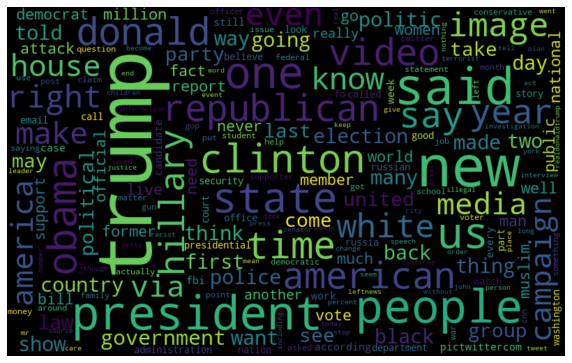

In [ ]:
#wordcloud for fake news articles
wordcloud_gen(df_final, "article", "FAKE")

Word Cloud for true news articles

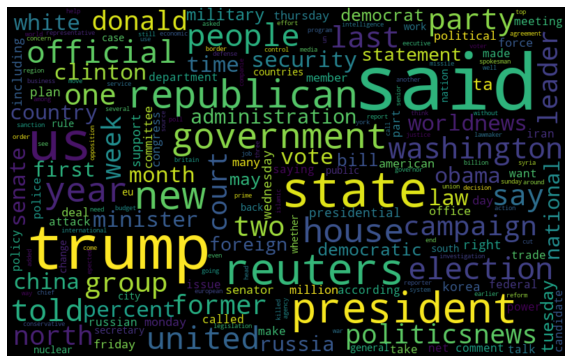

In [ ]:
#wordcloud for true news articles
wordcloud_gen(df_final, "article", "TRUE")

In [ ]:
#histogram generating function for whole corpus
def complete_corpus(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

Histogram for complete corpus 20 most frequent words

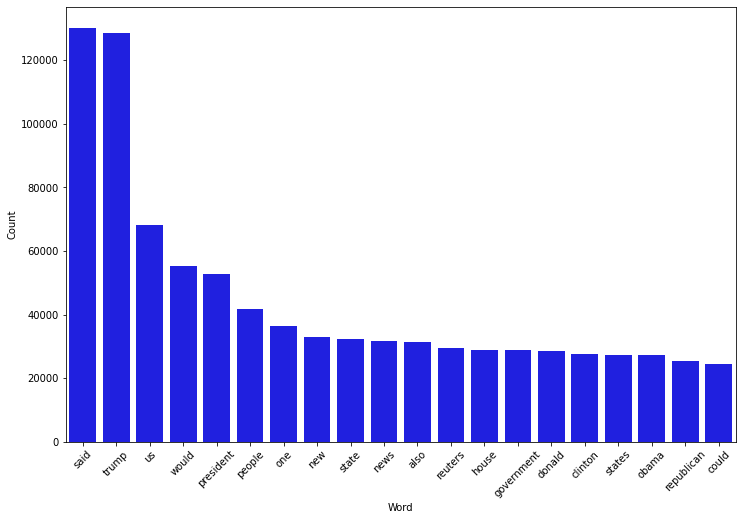

In [ ]:
#generating histogram for top 20 most frequent words
complete_corpus(df_final, "article", 20)

In [ ]:
#histogram generating function for true and fake news seperately
def histo_gen(text, column_text, quantity, label):
    true_text = text.query(f"label == '{label}'")
    all_words = ' '.join([text for text in true_text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

Histogram for fake news corpus 20 most frequent words

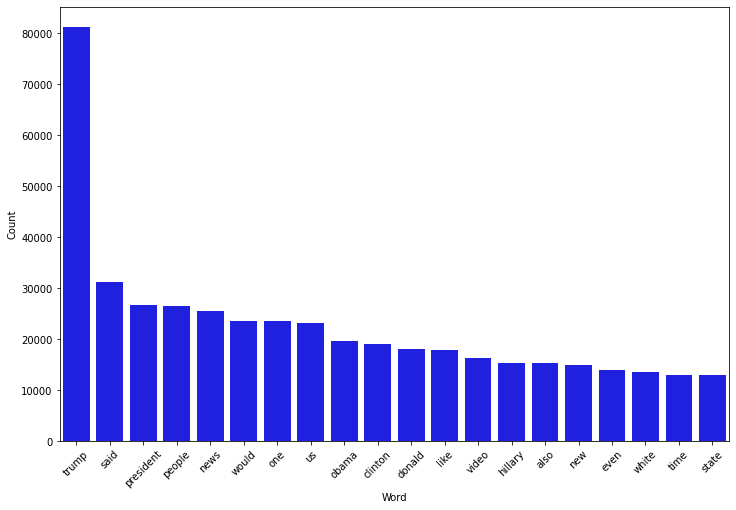

In [ ]:
#histogram for fake news corpus top 20 most frequent words
histo_gen(df_final, "article", 20, "FAKE")

Histogram for true news corpus 20 most frequent words

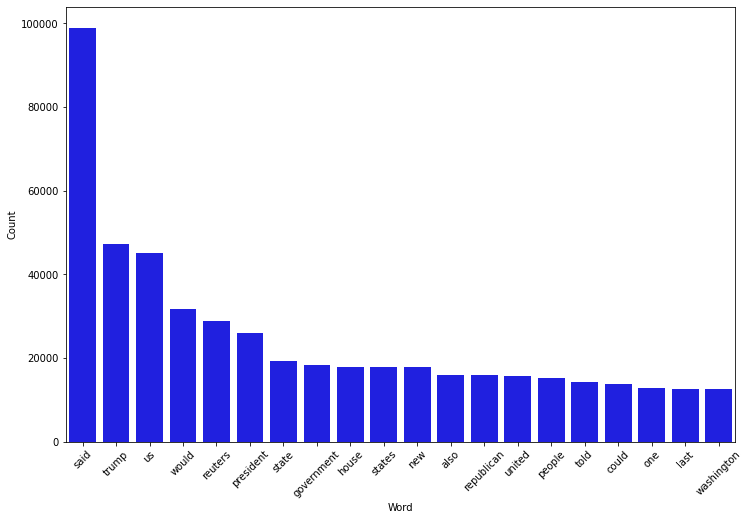

In [ ]:
#histogram for true news corpus top 20 most frequent words
histo_gen(df_final, "article", 20, "TRUE")

### Text Data Embedding

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000 
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 64

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_final['article'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 212102 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df_final['article'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (44898, 250)


In [ ]:
Y = pd.get_dummies(df_final['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (44898, 2)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35918, 250) (35918, 2)
(8980, 250) (8980, 2)


### LSTM model creation, training and evaluation

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))

model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           3200000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 3,233,154
Trainable params: 3,233,154
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/5
225/225 [==============================] - 155s 674ms/step - loss: 0.3457 - accuracy: 0.8889 - val_loss: 0.0061 - val_accuracy: 0.9992
Epoch 2/5
225/225 [==============================] - 150s 668ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/5
225/225 [==============================] - 151s 670ms/step - loss: 9.6253e-04 - accuracy: 0.9999 - val_loss: 2.4479e-04 - val_accuracy: 1.0000
Epoch 4/5
225/225 [==============================] - 151s 670ms/step - loss: 2.5924e-04 - accuracy: 1.0000 - val_loss: 1.2686e-04 - val_accuracy: 1.0000
Epoch 5/5
225/225 [==============================] - 150s 667ms/step - loss: 2.0941e-04 - accuracy: 1.0000 - val_loss: 7.1441e-05 - val_accuracy: 1.0000


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

281/281 [==============================] - 10s 37ms/step - loss: 7.9468e-05 - accuracy: 1.0000
Test set
  Loss: 0.000
  Accuracy: 1.000


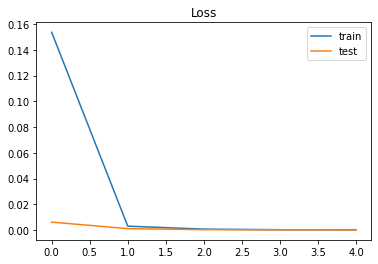

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

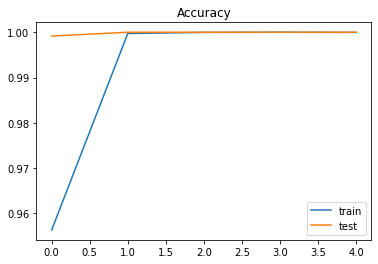

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
#testing with a self created article of fake and true statements mixed
text = ["Vote in Senate on 'Dreamers' hinges on bipartisan pact: McConnell WASHINGTON (Reuters) - U.S. Senate Majority Leader Mitch McConnell on Wednesday said he would bring a â€œDreamersâ€ immigration bill to the Senate floor if bipartisan negotiations between senators and the Trump administration produce an agreement by the end of January. McConnell also said in a statement that he would offer the measure as a â€œfree-standing vote,â€ without specifying when it would occur.In addition, the Benghazi investigation uncovered the existence of Clinton s private email server, which violated State Department policies and may also have broken laws regarding the handling of classified information. Clinton seems to have used the server to evade Freedom of Information Act (FOIA) requests, possibly in connection with fundraising for her family s private foundation while in office, including solicitations from foreign donors and governments. She has misled the public repeatedly about the email server, claiming falsely that she did not share classified information and that she had turned over all work-related emails to the government.Yet McConnell did not rule Clinton out. Instead, he said her presumptive Republican opponent, Donald Trump, had not yet proven himself qualified:Sen. Mitch McConnell:  Trump clearly needs to change, in my opinion, to win the general election. What I ve said to him both publicly and privately:  You re a great entertainer. You turn on audiences. You re good before a crowd. You have a lot of Twitter followers. That worked fine for you in the primaries."]
seq = tokenizer.texts_to_sequences(text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['FAKE', 'TRUE']
print(pred, labels[np.argmax(pred)])

[[9.9946886e-01 6.5237284e-04]] FAKE


In [ ]:
model.save('drive/MyDrive/saved_model/my_model1')
df_final.to_csv("drive/MyDrive/final.csv")

INFO:tensorflow:Assets written to: drive/MyDrive/saved_model/my_model1/assets


In [ ]:
from keras.models import load_model
model1 = load_model('drive/MyDrive/saved_model/my_model1')

In [ ]:
df_reddit = pd.read_csv('drive/MyDrive/Threads.csv')

In [ ]:
text1 = ["Las Vegas shooting: Isis claims responsibility for deadliest gun massacre in US history"]
seq = tokenizer.texts_to_sequences(text1)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model1.predict(padded)
labels = ['FAKE', 'TRUE']
print(pred, labels[np.argmax(pred)])

[[0.99656296 0.00409615]] FAKE


### Bi-Directional LSTM

In [ ]:
model2= Sequential()
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM,input_length=X.shape[1]))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(2,activation= 'sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           3200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 3,274,434
Trainable params: 3,274,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 5
batch_size = 64

history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
506/506 [==============================] - 199s 386ms/step - loss: 0.1834 - acc: 0.9230 - val_loss: 1.1116e-04 - val_acc: 1.0000
Epoch 2/5
506/506 [==============================] - 199s 392ms/step - loss: 6.3199e-05 - acc: 1.0000 - val_loss: 4.4893e-05 - val_acc: 1.0000
Epoch 3/5
506/506 [==============================] - 193s 381ms/step - loss: 1.6591e-05 - acc: 1.0000 - val_loss: 1.3687e-05 - val_acc: 1.0000
Epoch 4/5
506/506 [==============================] - 194s 384ms/step - loss: 7.7091e-06 - acc: 1.0000 - val_loss: 8.3461e-06 - val_acc: 1.0000
Epoch 5/5
506/506 [==============================] - 196s 387ms/step - loss: 4.1483e-06 - acc: 1.0000 - val_loss: 5.4701e-06 - val_acc: 1.0000


In [ ]:
accr = model2.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

281/281 [==============================] - 15s 53ms/step - loss: 5.6358e-06 - acc: 1.0000
Test set
  Loss: 0.000
  Accuracy: 1.000


In [ ]:
model2.save('drive/MyDrive/saved_model/Bi-LSTM')

INFO:tensorflow:Assets written to: drive/MyDrive/saved_model/Bi-LSTM/assets


INFO:tensorflow:Assets written to: drive/MyDrive/saved_model/Bi-LSTM/assets


In [ ]:
from keras.models import load_model
model3 = load_model('drive/MyDrive/saved_model/Bi-LSTM')

In [ ]:
text1 = ["Las Vegas shooting: Isis claims responsibility for deadliest gun massacre in US history"]
seq = tokenizer.texts_to_sequences(text1)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model3.predict(padded)
labels = ['FAKE', 'TRUE']
print(pred, labels[np.argmax(pred)])

[[9.9979568e-01 2.7745962e-04]] FAKE
